In [6]:
curr_loss = 0
val_loss = 100
for epoch in range(100):
    net.train()
    for idx, data in enumerate(text_dataloader,0):
        inputs, labels = data
        inputs = inputs.type(torch.cuda.FloatTensor).transpose(0,1)
        labels = labels.type(torch.cuda.LongTensor)
        optimizer.zero_grad()
    
        outputs = net(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
    
        loss.backward()
        curr_loss += loss.item()
    
        optimizer.step()
    
        if idx % 100 == 99:
        
            loss_history.append(curr_loss / 100)
            loss_iter_history.append(loss_curr_iter)
            loss_curr_iter += 1
        
            loss_axis.lines[0].set_xdata(loss_iter_history)
            loss_axis.lines[0].set_ydata(loss_history)
        
            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
            print(idx + 1, curr_loss / 100)
            
            curr_loss = 0
    net.eval()
    for idx, data in enumerate(val_dataloader, 0):
        inputs, labels = data
        inputs = inputs.type(torch.cuda.FloatTensor).transpose(0,1)
        labels = labels.type(torch.cuda.LongTensor)
        outputs = net(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        curr_loss += loss.item()
    mean_loss = curr_loss / len(val_dataloader)
    
    if mean_loss < val_loss:
        val_loss = mean_loss
        print(mean_loss)
        torch.save(net.state_dict(), '/home/max/text_generation_with_rnn/Ed_Sheeran_lyrics_gen_dropout_0.25_best_val.pth')
    #print(loss.item())
    

100 0.470081342487
200 0.464186511673
300 0.436064095572
400 0.446094747633


Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/max/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/max/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
  File "/home/max/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/max/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/max/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    self._target(*self._args, **self._kwargs)
  File "/home/max/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/max/anaconda2/lib/python2.7/multipro

KeyboardInterrupt: 

In [6]:
def inverse_sampling(probs):
    number = float(np.random.uniform(0, 1, size=1))
    sum_ = 0
    for k in range(len(probs) + 1):
        if sum_ < number:
            sum_ += probs[k]
        else:
            return k - 1
array = [0.25, 0.5, 0.25]
array = torch.distributions.categorical.Categorical(torch.Tensor(array))
print(array.sample().item())


1


In [27]:
def lyrics_sampling(start_sample, temperature=1, length=200):
    net.eval()
    for i in range(length):
        inputs = One_hot(torch.Tensor([char_to_idx[s] for s in start_sample[i: i + 12]]),voc_size)
        inputs = inputs.unsqueeze(0)
        inputs = inputs.transpose(0,1)
        inputs = inputs.expand(12, 4, 69)
        inputs = inputs.cuda()
        outputs = net(inputs)
        outputs = torch.sum(outputs, dim=0)/text_dataloader.batch_size
        outputs = torch.distributions.categorical.Categorical(logits=outputs.div(temperature))
        idx = outputs.sample().item()
        letter = idx_to_char[int(idx)]
        start_sample += letter
    return start_sample
print(lyrics_sampling('Let my heart', temperature=0.9))

Let my heart is falling too
I'm in love with an English man
Kissed her on the hill
Overing something brand new
I'm in love with an English man
Kissed her on the necklace you got the pain
And I loving hand
To help


In [1]:
def One_hot(inputs, num_classes):
    num_dims = inputs.dim()
    inputs_ = inputs.unsqueeze(num_dims).type(torch.LongTensor)
    inputs_shape = list(inputs.size())
    inputs_shape.append(num_classes)
    new_inputs = torch.zeros(size=inputs_shape).type(inputs.type())
    return new_inputs.scatter_(num_dims, inputs_, 1)

In [2]:
from torch.utils.data import Dataset, DataLoader
%matplotlib notebook
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import unicodedata
from __future__ import unicode_literals, print_function, division
import string
CUDA_LAUNCH_BLOCKING=1 


with open('/home/max/text_generation_with_rnn/Ed_Sheeran_lyrics_train.txt', 'r') as file:
    text = file.read()
    file.close()
text = text.decode("utf-8").encode("ascii", "ignore")
text = text.split(' ')
text = ' '.join(text)
chars = sorted(list(set(text)))
char_to_idx = dict((char, idx) for idx, char in enumerate(chars))
idx_to_char = dict((idx, char) for idx, char in enumerate(chars))
voc_size = len(chars)


class TextGenLyricsDataset(Dataset):
    
    def __init__(self, text_file, root_dir, transform=None):
        with open(root_dir + text_file, 'r') as file:
            self.text_file = file.read()
            file.close()
        self.text_file = self.text_file.decode("utf-8").encode("ascii", "ignore")
        self.text_file = self.text_file.split(' ')
        self.text_file = ' '.join(self.text_file)
        self.sequences = []
        for i in range(12, len(self.text_file)):
            self.sequences.append(self.text_file[i - 12 : i + 1])
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        input_seq = self.sequences[idx][:-1]
        letter = self.sequences[idx][-1]
        input_seq = torch.Tensor([char_to_idx[s] for s in input_seq])
        letter = torch.Tensor([char_to_idx[letter]])
        input_seq = One_hot(input_seq, voc_size)
        return input_seq, letter 

In [3]:
text_dataset = TextGenLyricsDataset('Ed_Sheeran_lyrics_train.txt','/home/max/text_generation_with_rnn/')
val_dataset = TextGenLyricsDataset('Ed_Sheeran_lyrics_val.txt','/home/max/text_generation_with_rnn/')

In [4]:
text_dataloader = DataLoader(text_dataset, batch_size=4, shuffle=True, num_workers=2,drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2,drop_last=True)

<IPython.core.display.Javascript object>


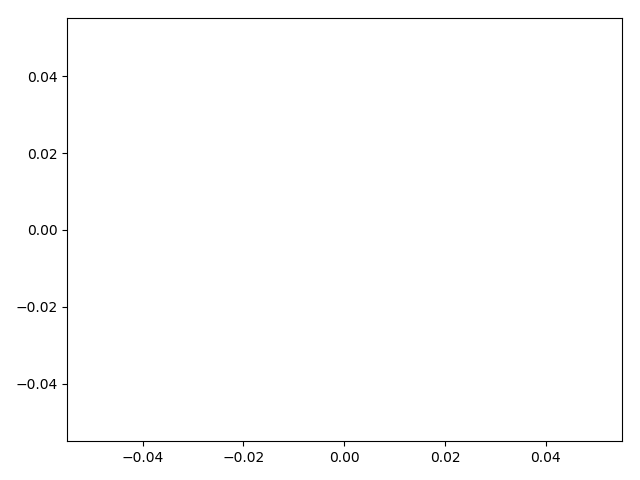

In [5]:
class Net(nn.Module):
    
    
    def __init__(self):
        super(Net, self).__init__()
        self.LSTM = nn.LSTM(voc_size, 50, 2)
        self.dropout = nn.Dropout(p=0.25)
        self.linear = nn.Linear(text_dataloader.batch_size * 600, text_dataloader.batch_size * voc_size)
        self.hidden = nn.Parameter(torch.randn(2, text_dataloader.batch_size, 50, requires_grad=True).cuda())
        self.cell = nn.Parameter(torch.randn(2, text_dataloader.batch_size, 50, requires_grad=True).cuda())
    
    def forward(self, x):
        x, (_, _) = self.LSTM(x, (self.hidden, self.cell))
        x = self.dropout(x)
        #x = x.transpose(0, 1).contiguous()
        x = self.linear(x.view(-1))
        x = x.view(text_dataloader.batch_size, -1)
        return x
            

net = Net().cuda()
net.train()
net.load_state_dict(torch.load('/home/max/text_generation_with_rnn/Ed_Sheeran_lyrics_gen_dropout_0.25.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)


loss_history = []
loss_iter_history = []
loss_curr_iter = 0

f, loss_axis = plt.subplots(1,1)
loss_axis.plot(loss_history, loss_iter_history, 'r')

plt.tight_layout()